C:\Users\asidd\AppData\Local\Temp\ipykernel_17728\608654523.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bridges_2023_not_2022.loc[:, 'LAT_016_dd'] = bridges_2023_not_2022['LAT_016_x'].apply(lambda x: dms_to_dd(x, is_latitude=True))
C:\Users\asidd\AppData\Local\Temp\ipykernel_17728\608654523.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bridges_2023_not_2022.loc[:, 'LONG_017_dd'] = bridges_2023_not_2022['LONG_017_x'].apply(lambda x: dms_to_dd(x, is_latitude=False))


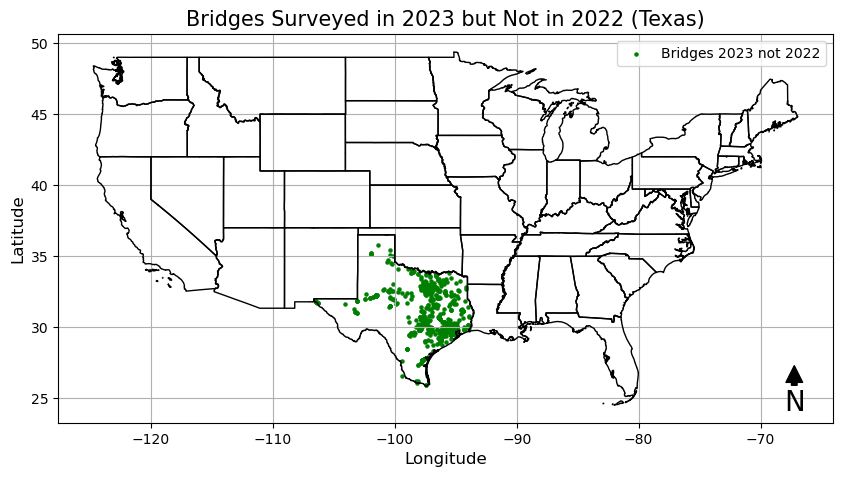

In [4]:
# Import Libraries
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from matplotlib import pyplot as plt

# Function to convert DMS to Decimal Degrees
def dms_to_dd(dms_value, is_latitude=True):
    try:
        degrees = int(dms_value / 1000000)
        minutes = int((dms_value - degrees * 1000000) / 10000)
        seconds = (dms_value - degrees * 1000000 - minutes * 10000) / 100
        
        decimal_degrees = degrees + (minutes / 60) + (seconds / 3600)
        
        return decimal_degrees if is_latitude else -decimal_degrees
    except Exception as e:
        print(f"Error in conversion: {e}")
        return None

# Load the datasets with dtype specification
tx22 = pd.read_csv(r'C:\Users\asidd\OneDrive\Desktop\GIS_Data\TX_CSV\tx22.csv', low_memory=False)
tx23 = pd.read_csv(r'C:\Users\asidd\OneDrive\Desktop\GIS_Data\TX_CSV\tx23.csv', low_memory=False)

# Ensure unique bridges in 2023 dataset
tx23_unique = tx23.drop_duplicates(subset='STRUCTURE_NUMBER_008')

# Merge datasets
merged_bridges = pd.merge(tx23_unique, tx22, on='STRUCTURE_NUMBER_008', how='left', indicator=True)

# Filter for bridges in 2023 but not in 2022
bridges_2023_not_2022 = merged_bridges[merged_bridges['_merge'] == 'left_only']

# Convert latitude and longitude from DMS to Decimal Degrees
bridges_2023_not_2022.loc[:, 'LAT_016_dd'] = bridges_2023_not_2022['LAT_016_x'].apply(lambda x: dms_to_dd(x, is_latitude=True))
bridges_2023_not_2022.loc[:, 'LONG_017_dd'] = bridges_2023_not_2022['LONG_017_x'].apply(lambda x: dms_to_dd(x, is_latitude=False))

# Drop rows with missing latitude or longitude
bridges_2023_not_2022 = bridges_2023_not_2022.dropna(subset=['LAT_016_dd', 'LONG_017_dd'])

# Create a GeoDataFrame with the converted coordinates
geometry = [Point(xy) for xy in zip(bridges_2023_not_2022['LONG_017_dd'], bridges_2023_not_2022['LAT_016_dd'])]
gdf = gpd.GeoDataFrame(bridges_2023_not_2022, geometry=geometry)

# Set the initial CRS to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Reproject to NAD83
gdf = gdf.to_crs(epsg=4269)

# Load the map
map_gdf = gpd.read_file(r'C:\Users\asidd\OneDrive\Desktop\GIS_Data\TX_CSV\Conus83.gpkg')

# Ensure map is in EPSG:4269
if map_gdf.crs.to_epsg() != 4269:
    map_gdf = map_gdf.to_crs(epsg=4269)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
map_gdf.boundary.plot(ax=ax, linewidth=1, color='black')

# Plot the bridges
gdf.plot(ax=ax, color='green', marker='o', markersize=5, label='Bridges 2023 not 2022')

# Add north arrow
x, y, arrow_length = 0.95, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')

# Customize the map
ax.set_title('Bridges Surveyed in 2023 but Not in 2022 (Texas)', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [6]:
# Save the filtered data to a CSV file
bridges_2023_not_2022.to_csv(r'C:\Users\asidd\OneDrive\Desktop\GIS_Data\TX_CSV\filtered_bridges_2023_not_2022.csv', index=False)


In [16]:
# Select relevant columns
selected_columns = bridges_2023_not_2022[['DECK_COND_058_x', 'CHANNEL_COND_061_x', 'CULVERT_COND_062_x']]

# Define a function to categorize the condition ratings
def categorize_condition(value):
    try:
        value = int(value)
        if 0 <= value <= 5:
            return 0  # Less than Satisfactory
        elif 6 <= value <= 9:
            return 1  # Satisfactory or better
    except:
        if value == 'N':
            return 1  # N for Not Applicable (Satisfactory or better)
        return None  # Handle unexpected cases

# Apply the categorization function to the selected columns
bridges_2023_not_2022['DECK_COND_058_Category'] = selected_columns['DECK_COND_058_x'].apply(categorize_condition)
bridges_2023_not_2022['CHANNEL_COND_061_Category'] = selected_columns['CHANNEL_COND_061_x'].apply(categorize_condition)
bridges_2023_not_2022['CULVERT_COND_062_Category'] = selected_columns['CULVERT_COND_062_x'].apply(categorize_condition)

# Display the categorized data (or save it to CSV if needed)
print(bridges_2023_not_2022[['DECK_COND_058_Category', 'CHANNEL_COND_061_Category', 'CULVERT_COND_062_Category']].head())


     DECK_COND_058_Category  CHANNEL_COND_061_Category  \
9                         1                          1   
115                       1                          1   
584                       1                          1   
585                       1                          1   
586                       1                          1   

     CULVERT_COND_062_Category  
9                            1  
115                          1  
584                          1  
585                          1  
586                          1  


In [34]:
# Save the filtered data to a CSV file
bridges_2023_not_2022.to_csv(r'C:\Users\asidd\OneDrive\Desktop\GIS_Data\TX_CSV\filtered_bridges_2023_not_2022.csv', index=False)
bridges_2023_not_2022


,STATE_CODE_001_x,STRUCTURE_NUMBER_008,RECORD_TYPE_005A_x,ROUTE_PREFIX_005B_x,SERVICE_LEVEL_005C_x,ROUTE_NUMBER_005D_x,DIRECTION_005E_x,HIGHWAY_DISTRICT_002_x,COUNTY_CODE_003_x,PLACE_CODE_004_x,...,SUBMITTED_BY_y,BRIDGE_CONDITION_y,LOWEST_RATING_y,DECK_AREA_y,_merge,LAT_016_dd,LONG_017_dd,DECK_COND_058_Category,CHANNEL_COND_061_Category,CULVERT_COND_062_Category
9,48,000021594-62610,1,6,0,00000,0,2,203,0,...,NaN,NaN,NaN,NaN,left_only,32.680500,-94.145833,1,1,1
115,48,010600AA2130001,1,4,1,02130,0,1,119,0,...,NaN,NaN,NaN,NaN,left_only,33.371656,-95.774397,1,1,1
584,48,010920004702684,1,2,1,00075,1,1,181,39200,...,NaN,NaN,NaN,NaN,left_only,33.628550,-96.613514,1,1,1
585,48,010920004702685,1,2,1,00075,3,1,181,39200,...,NaN,NaN,NaN,NaN,left_only,33.628522,-96.613681,1,1,1
586,48,010920004702686,1,2,1,00075,1,1,181,39200,...,NaN,NaN,NaN,NaN,left_only,33.637911,-96.616428,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56296,48,DAPFORHOO0BVM20,1,8,0,00000,0,9,99,26736,...,NaN,NaN,NaN,NaN,left_only,31.155450,-97.816239,1,1,1
56310,48,NCA1,1,6,0,00000,0,0,113,19000,...,NaN,NaN,NaN,NaN,left_only,32.717314,-96.936814,1,1,1
56311,48,NCA2,1,6,0,00000,0,0,113,19000,...,NaN,NaN,NaN,NaN,left_only,32.713853,-96.934181,1,1,0
56312,48,NCA3,1,6,0,00000,0,0,113,19000,...,NaN,NaN,NaN,NaN,left_only,32.712667,-96.937056,1,1,1


In [42]:
# Select relevant columns
selected_columns = bridges_2023_not_2022[['DECK_COND_058_x', 'CHANNEL_COND_061_x', 'CULVERT_COND_062_x','LAT_016_x','LONG_017_x','MAINTENANCE_021_x','FUNCTIONAL_CLASS_026_x',
                                         'YEAR_BUILT_027_x','TRAFFIC_LANES_ON_028A_x','ADT_029_x','INSPECT_FREQ_MONTHS_091_x','YEAR_RECONSTRUCTED_106_x','PERCENT_ADT_TRUCK_109_x',
                                         'DEGREES_SKEW_034_x','STRUCTURE_KIND_043A_x','STRUCTURE_TYPE_043B_x','MAIN_UNIT_SPANS_045_x','MAX_SPAN_LEN_MT_048_x','STRUCTURE_LEN_MT_049_x',
                                         'ROADWAY_WIDTH_MT_051_x','DECK_STRUCTURE_TYPE_107_x','SURFACE_TYPE_108A_x','MEMBRANE_TYPE_108B_x','DECK_PROTECTION_108C_x','SUPERSTRUCTURE_COND_059_x',
                                          'DECK_COND_058_x','SUPERSTRUCTURE_COND_059_x','SUBSTRUCTURE_COND_060_x','CHANNEL_COND_061_x', 'CULVERT_COND_062_x']]
bridges_2023_not_2022


,STATE_CODE_001_x,STRUCTURE_NUMBER_008,RECORD_TYPE_005A_x,ROUTE_PREFIX_005B_x,SERVICE_LEVEL_005C_x,ROUTE_NUMBER_005D_x,DIRECTION_005E_x,HIGHWAY_DISTRICT_002_x,COUNTY_CODE_003_x,PLACE_CODE_004_x,...,SUBMITTED_BY_y,BRIDGE_CONDITION_y,LOWEST_RATING_y,DECK_AREA_y,_merge,LAT_016_dd,LONG_017_dd,DECK_COND_058_Category,CHANNEL_COND_061_Category,CULVERT_COND_062_Category
9,48,000021594-62610,1,6,0,00000,0,2,203,0,...,NaN,NaN,NaN,NaN,left_only,32.680500,-94.145833,1,1,1
115,48,010600AA2130001,1,4,1,02130,0,1,119,0,...,NaN,NaN,NaN,NaN,left_only,33.371656,-95.774397,1,1,1
584,48,010920004702684,1,2,1,00075,1,1,181,39200,...,NaN,NaN,NaN,NaN,left_only,33.628550,-96.613514,1,1,1
585,48,010920004702685,1,2,1,00075,3,1,181,39200,...,NaN,NaN,NaN,NaN,left_only,33.628522,-96.613681,1,1,1
586,48,010920004702686,1,2,1,00075,1,1,181,39200,...,NaN,NaN,NaN,NaN,left_only,33.637911,-96.616428,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56296,48,DAPFORHOO0BVM20,1,8,0,00000,0,9,99,26736,...,NaN,NaN,NaN,NaN,left_only,31.155450,-97.816239,1,1,1
56310,48,NCA1,1,6,0,00000,0,0,113,19000,...,NaN,NaN,NaN,NaN,left_only,32.717314,-96.936814,1,1,1
56311,48,NCA2,1,6,0,00000,0,0,113,19000,...,NaN,NaN,NaN,NaN,left_only,32.713853,-96.934181,1,1,0
56312,48,NCA3,1,6,0,00000,0,0,113,19000,...,NaN,NaN,NaN,NaN,left_only,32.712667,-96.937056,1,1,1


In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Assuming 'bridges_2023_not_2022' is your DataFrame
# Select the independent variables
X = bridges_2023_not_2022[['LAT_016_x', 'LONG_017_x', 'MAINTENANCE_021_x', 'FUNCTIONAL_CLASS_026_x',
                           'YEAR_BUILT_027_x', 'TRAFFIC_LANES_ON_028A_x', 'ADT_029_x', 'INSPECT_FREQ_MONTHS_091_x',
                           'YEAR_RECONSTRUCTED_106_x', 'PERCENT_ADT_TRUCK_109_x', 'DEGREES_SKEW_034_x',
                           'STRUCTURE_KIND_043A_x', 'STRUCTURE_TYPE_043B_x', 'MAIN_UNIT_SPANS_045_x', 'MAX_SPAN_LEN_MT_048_x',
                           'STRUCTURE_LEN_MT_049_x', 'ROADWAY_WIDTH_MT_051_x', 'DECK_STRUCTURE_TYPE_107_x',
                           'SURFACE_TYPE_108A_x', 'MEMBRANE_TYPE_108B_x', 'DECK_PROTECTION_108C_x', 'SUPERSTRUCTURE_COND_059_x',
                           'SUBSTRUCTURE_COND_060_x']]

# Convert any categorical features into numeric
X = pd.get_dummies(X, drop_first=True)

# Impute missing values (fill with the mean value for each column)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Logistic Regression for each target variable (now using category columns)
for target in ['DECK_COND_058_Category', 'CHANNEL_COND_061_Category', 'CULVERT_COND_062_Category']:
    y = bridges_2023_not_2022[target]
    
    # If the target is categorical, we encode it using LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create and train the model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Display results
    print(f"Results for {target}:")
    print(classification_report(y_test, y_pred))
    print("\n")


Results for DECK_COND_058_Category:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       295

    accuracy                           1.00       295
   macro avg       1.00      1.00      1.00       295
weighted avg       1.00      1.00      1.00       295



Results for CHANNEL_COND_061_Category:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.99      1.00      0.99       291

    accuracy                           0.99       295
   macro avg       0.49      0.50      0.50       295
weighted avg       0.97      0.99      0.98       295



Results for CULVERT_COND_062_Category:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.99      0.99       294

    accuracy                           0.99       295
   macro avg       0.50      0.50      0.50       295
weighted a

C:\Users\asidd\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asidd\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asidd\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
